In [1]:
import numpy as np
import numba as nb
from numba.typed import List
import pandas as pd
import itertools
from operator import itemgetter
import gc

from scipy.stats import norm, lognorm, truncnorm
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter, deque
from sys import getsizeof
from sedgen.initialization import SedGen
from sedgen import initialization as ini
from sedgen import general as gen
from sedgen import preprocessing
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Load jupyter extension to reload packages before executing user code.
# https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
# Reload all packages (except those excluded by %aimport) every time 
# before executing the Python code typed.
%autoreload 2

In [6]:
def optimise_learnrate(minerals, par_rock_volume, modal_mineralogy, means, stds):
    learnrate = 500
    counter = 0
    while counter != 10:
        model = SedGen(minerals, par_rock_volume, modal_mineralogy, means, stds, learning_rate=learnrate, discretization_init=False, timed=True)
        modelled_volume = np.sum(model.simulated_volume)
        print("Parent rock volume:", par_rock_volume)
        print("Simulated volume:", modelled_volume)
        if modelled_volume < ((par_rock_volume*0.0001)+par_rock_volume) and modelled_volume> (par_rock_volume-(par_rock_volume*0.0001)): 
            break
        else:
            learnrate *= 2
        print("Counter:", counter, "Learnrate:", learnrate)
        counter += 1
    pluton_learnrate = learnrate * par_rock_volume
    return (pluton_learnrate)

In [3]:
minerals = ["Q", "P", "K", "B", "O", "A"]

In [4]:
modal_mineralogy = np.array([[0.16331256, 0.46387757, 0.12683457, 0.05758711, 0.01078412, 0.17760407],   # AZ
                             [0.27453254, 0.40124204, 0.24993859, 0.02509231, 0.00454988, 0.04464465],   # CA-EW
                             [0.30591989, 0.38159713, 0.26209888, 0.0188256 , 0.00799247, 0.02356603],   # CA-NS
                             [0.19781274, 0.41766034, 0.16121575, 0.06478527, 0.00894429, 0.14958161],   # GR
                             [0.25983144, 0.46392506, 0.15827298, 0.04370113, 0.00689158, 0.06737782],   # MT
                             [0.22419158, 0.48490082, 0.05641885, 0.11571367, 0.00000001, 0.11877509]])
print(modal_mineralogy[0])

[0.16331256 0.46387757 0.12683457 0.05758711 0.01078412 0.17760407]


In [5]:
csds_AZ_means = np.array([0.120, 0.174, 0.112, 0.155, 0.066, 0.079])
csds_AZ_stds = np.array([0.359, 0.356, 0.455, 0.399, 0.328, 0.452])

csds_CA_EW_means = np.array([0.247, 0.333, 0.292, 0.212, 0.090, 0.127])
csds_CA_EW_stds = np.array([0.986, 0.640, 0.497, 0.889, 0.275, 0.502])

csds_CA_NS_means = np.array([0.309, 0.330, 0.244, 0.223, 0.120, 0.122])
csds_CA_NS_stds = np.array([0.823, 0.683, 0.817, 0.819, 0.554, 0.782])

csds_GR_means = np.array([0.244, 0.269, 0.222, 0.251, 0.059, 0.107])
csds_GR_stds = np.array([0.312, 0.450, 0.444, 0.262, 0.378, 0.313])

csds_MT_means = np.array([0.220, 0.227, 0.160, 0.153, 0.078, 0.075])
csds_MT_stds = np.array([0.472, 0.415, 0.344, 0.363, 0.315, 0.599])

csds_WA_means = np.array([0.342, 0.385, 0.241, 0.481, 0.001, 0.130])
csds_WA_stds = np.array([0.542, 0.478, 0.386, 0.467, 0.001, 0.494])


weightedmeanAZ = np.sum(modal_mineralogy[0]*csds_AZ_means)
weightedmeanCA_EW = np.sum(modal_mineralogy[1]*csds_CA_EW_means)
weightedmeanCA_NS = np.sum(modal_mineralogy[2]*csds_CA_NS_means)
weightedmeanGR = np.sum(modal_mineralogy[3]*csds_GR_means)
weightedmeanMT = np.sum(modal_mineralogy[4]*csds_MT_means)
weightedmeanWA = np.sum(modal_mineralogy[5]*csds_WA_means)

print(weightedmeanAZ,weightedmeanCA_EW,weightedmeanCA_NS,weightedmeanGR,weightedmeanMT,weightedmeanWA)

0.13818615172 0.28580413444999997 0.29244068649000005 0.22920088467000002 0.20007473485000002 0.3480563158900001


In [7]:
learnvalueAZ = optimise_learnrate(minerals, 1e9, modal_mineralogy[0], csds_AZ_means, csds_AZ_stds)
learnvalueCA_EW = optimise_learnrate(minerals, 1e9, modal_mineralogy[1], csds_CA_EW_means, csds_CA_EW_stds)
learnvalueCA_NS = optimise_learnrate(minerals, 1e9, modal_mineralogy[2], csds_CA_NS_means, csds_CA_EW_stds)
learnvalueGR = optimise_learnrate(minerals, 1e9, modal_mineralogy[3], csds_GR_means, csds_GR_stds)
learnvalueMT = optimise_learnrate(minerals, 1e9, modal_mineralogy[4], csds_MT_means, csds_MT_stds)
learnvalueWA = optimise_learnrate(minerals, 1e9, modal_mineralogy[5], csds_WA_means, csds_WA_stds)
xaxis = np.array([learnvalueAZ, learnvalueCA_EW, learnvalueCA_NS, learnvalueGR, learnvalueMT, learnvalueWA])

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|2000001, 1921469, 1851370, 1782765, 1715469, 1651960, 1589982, 1532077, 1474187, 1421360, 1367266, 1317296, 1266691, 1219659, 1175768, 1130966, 1086830, 1047075, 1009394, 971979, 935908, 901627, 867421, 836009, 804308, 775504, 747380, 718510, 690293, 662110, 637277, 613938, 590550, 568102, 546704, 526725, 507104, 489598, 472103, 453856, 436269, 420417, 405250, 390835, 375515, 360804, 346118, 332428, 319746, 307319, 295311, 284008, 273564, 262478, 252649, 242613, 233280, 223208, 215601, 206411, 198512, 191077, 185097, 178203, 171566, 164420, 158312, 153145, 148009, 141175, 136815, 130918, 126007, 121100, 117136, 113309, 108322, 103775, 99625, 96093, 92153, 88524, 86249, 82798, 79677, 76602, 73488, 70547, 68022, 65262, 63031, 60811, 58912, 56355, 53473, 51440, 49567, 47615, 46289, 44225, 42549, 40986, 39215, 37658, 36262, 34681, 33170, 

[5.e+11 8.e+12 8.e+12 5.e+11 5.e+11 1.e+12] [0.13818615 0.28580413 0.29244069 0.22920088 0.20007473 0.34805632]


Text(0, 0.5, 'weighted grain size')

Text(0.5, 0, 'learnvalue for plutons')

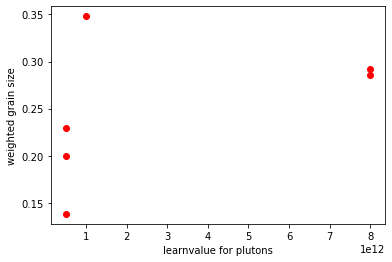

In [10]:
yaxis = np.array([weightedmeanAZ,weightedmeanCA_EW,weightedmeanCA_NS,weightedmeanGR,weightedmeanMT,weightedmeanWA])
plt.plot(xaxis, yaxis, 'ro')
print(xaxis,yaxis)
plt.ylabel('weighted grain size')
plt.xlabel('learnvalue for plutons')